In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gurobipy import Model, GRB, quicksum
from Services.read_data import Dados
import math
import pandas as pd

In [3]:
# Inicialização da classe Dados
file_name = 'Dados\Modelo.xlsx'
dados = Dados(file_name)

In [4]:
# Definir conjuntos (como exemplo, defina os conjuntos de portos, tipos de contêineres, etc.)
P = dados.P  # Exemplo de 9 portos
K = dados.K   # Exemplo de 3 tipos de contêineres
C = dados.C   # Exemplo de 5 tipos de carga
T = dados.T  # Exemplo de 12 períodos de tempo

# Uso de dados.M com índice rota está dando errado

Qual a ordem? Queremos descobrir a ordem?

PNG, SSZ, SUA, PEC, MAO, MAO, PEC, SUA, SSZ, PNG

Isso são 10 portos, mas faria sentido desconsiderar um MAO do meio. Ficamos com rota de 9 portos?

ID Portos:

1: PEC; 2: PNG; 3: MAO; 4: SUA; 5: SSZ 

MAO aparece duas veze > subida e descida, mas não há fluxo

In [5]:
#       [1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
ordem = [2, 5, 4, 1, 3, 3, 1, 4, 5, 2]
# j > i; sum i > j / t <= demanda(i,j,t)
ordem = pd.DataFrame(ordem, index=[i + 1 for i in range(len(ordem))], columns=['IdPorto'])

Porto 9 p 5 tem carregamento

Mas isso é do porto 5 pro 3

Não seria o mesmo que ir do porto de índice rota 2 p 5? (já que o porto 5 na rota é o 9 e o 2)

Colocar frete alto de 5 p 1 faz o modelo pegar tudo nesse trecho (idx 2 a 4) e faz ir a zero o 2 a 5 (5 pro 3)

Isso faz sentido pois precisa liberar espaço pro frete mais alto

Mas ainda não entendo se faz sentido ter os mesmo valores do 9 pro 4 (pq o 9 ainda é o porto 2)

In [6]:
dados.RF[(dados.RF['I'] == 5) & (dados.RF['J'] == 1) & (dados.RF['K'] == 3) & (dados.RF['C'] == 1)]

,I,J,K,C,T,RF
23,5,1,3,1,1,50000.0
88,5,1,3,1,2,10450.0
153,5,1,3,1,3,10450.0
218,5,1,3,1,4,10450.0
283,5,1,3,1,5,10450.0
348,5,1,3,1,6,10450.0
413,5,1,3,1,7,10450.0
478,5,1,3,1,8,150000.0
543,5,1,3,1,9,10450.0
608,5,1,3,1,10,10450.0


In [7]:
port_nums = dados.RF['I'].drop_duplicates().values
port_nums.sort()
port_nums

array([1, 2, 3, 4, 5], dtype=int64)

In [8]:
# Criar o modelo
model = Model("Modelo de Otimização de Cabotagem")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-27


# Usar model.AddConstrs?

In [9]:
ordem

,IdPorto
1,2
2,5
3,4
4,1
5,3
6,3
7,1
8,4
9,5
10,2


In [10]:
CT = model.addVar(vtype=GRB.CONTINUOUS, name="CT", lb=0, ub=1)  # Margem de contribuição
FF = model.addVars(P, P, K, C, T, vtype=GRB.CONTINUOUS, name="FF")  # Contêineres cheios embarcados
FE = model.addVars(P, P, K, T, vtype=GRB.CONTINUOUS, name="FE")    # Contêineres vazios embarcados
E = model.addVars(P, K, T, vtype=GRB.CONTINUOUS, name="E")         # Estoque de contêineres vazios
R = model.addVars(P, T, vtype=GRB.CONTINUOUS, name="R")            # Quantidade de TEU no navio
RSF = model.addVars(P, K, T, vtype=GRB.CONTINUOUS, name="RSF")     # Contêineres vazios retornando
RSE = model.addVars(P, K, T, vtype=GRB.CONTINUOUS, name="RSE")     # Contêineres vazios disponíveis
RLF = model.addVars(P, K, T, vtype=GRB.CONTINUOUS, name="RLF")     # Contêineres vazios liberados para exportação
RLE = model.addVars(P, K, T, vtype=GRB.CONTINUOUS, name="RLE")     # Contêineres vazios liberados para reposicionamento
FF_port = model.addVars(port_nums, port_nums, K, C, T, vtype=GRB.CONTINUOUS, name='FF_port')

RESTRIÇÕES

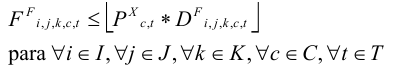

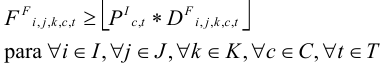

SF, SE, PI e PX são por ID de porto... Não por posição do porto na rota...

## Não rodando no teste de ajuste

In [11]:
# Restrições de participação máxima e mínima do armador no tipo de carga
count_constr = 0
for i in dados.P:
    for j in dados.P:
        for k in dados.K:
            for c in dados.C:
                for t in dados.T:
                    if j < i:
                        # Demanda apenas para frente
                        model.addConstr(
                            FF[i, j, k, c, t] == 0,
                            name=f"participacao_maxima_armador_{i}_{j}_{k}_{c}_{t}"
                        )
#                     else:
#                         df_filtered = dados.DF[ordem.loc[i].values[0], ordem.loc[j].values[0], k, c, t]
#                         px_filtered = dados.PX[(dados.PX['I'] == ordem.loc[i].values[0]) & (dados.PX['C'] == c) & (dados.PX['T'] == t)]
#                         pi_filtered = dados.PI[(dados.PI['I'] == ordem.loc[i].values[0]) & (dados.PI['C'] == c) & (dados.PI['T'] == t)]
                        
#                         count_constr += 1
#                         df_value = df_filtered
#                         px_value = px_filtered['PX'].values[0]
#                         pi_value = pi_filtered['PX'].values[0]
#                         model.addConstr(
#                             FF[i, j, k, c, t] <= math.floor(df_value * px_value),
#                             name=f"participacao_maxima_armador_{i}_{j}_{k}_{c}_{t}"
#                         )
#                         model.addConstr(
#                             FF[i, j, k, c, t] >= math.floor(df_value * pi_value),
#                             name=f"participacao_minima_armador_{i}_{j}_{k}_{c}_{t}"
#                         )

# print(f"Restrições de participação máxima e mínima do armador no tipo de carga: {count_constr} cada")

### Limite de demanda saindo de i para j em cada período t, índice do porto

In [12]:
for k in dados.K:
    for c in dados.C:
        for t in dados.T:
            for i_ in port_nums:
                for j_ in port_nums:
                    model.addConstr(FF_port[i_,j_,k,c,t] == quicksum([FF[i,j,k,c,t] for i in dados.P for j in dados.P if (ordem.loc[i].values[0] == i_ and ordem.loc[j].values[0] == j_)]),
                                    name=f'participacao_maxima_armador_{i_}_{j_}_{k}_{c}_{t} com índice do porto')
            

In [13]:
# Restrições de participação máxima e mínima do armador no tipo de carga
count_constr = 0
for i in port_nums:
    for j in port_nums:
        for k in dados.K:
            for c in dados.C:
                for t in dados.T:
                    if True:
                        # df_filtered = dados.DF[ordem.loc[i].values[0], ordem.loc[j].values[0], k, c, t]
                        df_filtered = dados.DF[i,j,k,c,t]
                        # px_filtered = dados.PX[(dados.PX['I'] == ordem.loc[i].values[0]) & (dados.PX['C'] == c) & (dados.PX['T'] == t)]
                        px_filtered = dados.PX[(dados.PX['I'] == i) & (dados.PX['C'] == c) & (dados.PX['T'] == t)]
                        # pi_filtered = dados.PI[(dados.PI['I'] == ordem.loc[i].values[0]) & (dados.PI['C'] == c) & (dados.PI['T'] == t)]
                        pi_filtered = dados.PI[(dados.PI['I'] == i) & (dados.PI['C'] == c) & (dados.PI['T'] == t)]
                        
                        count_constr += 1
                        df_value = df_filtered
                        px_value = px_filtered['PX'].values[0]
                        pi_value = pi_filtered['PX'].values[0]

                        # Utilizando o índice do porto, sem ajuste do ordem.loc para os dados de demanda DF
                        model.addConstr(
                            FF_port[i, j, k, c, t] <= math.floor(df_value * px_value),
                            name=f"participacao_maxima_armador_{i}_{j}_{k}_{c}_{t}"
                        )
                        model.addConstr(
                            FF_port[i, j, k, c, t] >= math.floor(df_value * pi_value),
                            name=f"participacao_minima_armador_{i}_{j}_{k}_{c}_{t}"
                        )

Alguns dados consideram os indices I, J como os IDs dos portos (de 1 a 5)

No caso das restrições, como FF, estamos considerando como índice de posição na rota (1 a 9)

Isso é o correto? (Acho que sim) Ou nas restrições, também devem ter índices de portos de 1 a 5?

Mesma dúvida para RSF, que considera SF(que utiliza índices de 1 a 5) e RSE

DF considerado zero para índices sem dados, todas as restrições de FF adicionadas (incluindo as que resultam em valor zero, dado DF = 0)

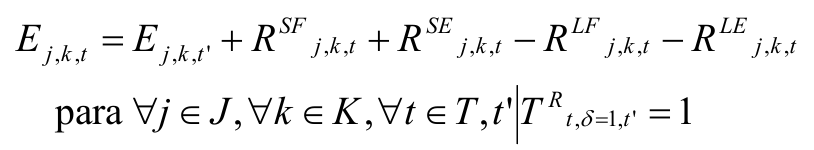

In [14]:
# Restrição de balanço de contêineres vazios nos portos
count_constr = 0
for j in dados.P:
    for k in dados.K:
        for t in dados.T:
            count_constr += 1
            model.addConstr(
                        E[j, k, t] == E[j, k, dados.T[-1] if t == 1 else t - 1] + RSE[j, k, t] + RSF[j, k, t] - RLE[j, k, t] - RLF[j, k, t],
                        name=f"balanco_conteineres_vazios_{j}_{k}_{t}"
                    )
print(f"Restrições de balanço de contêineres vazios nos portos: {count_constr}")


Restrições de balanço de contêineres vazios nos portos: 480


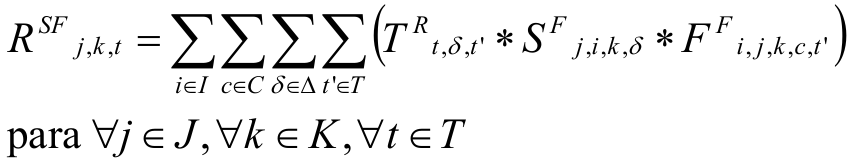

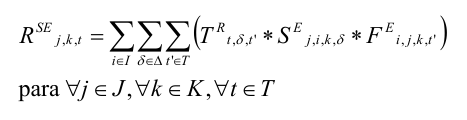

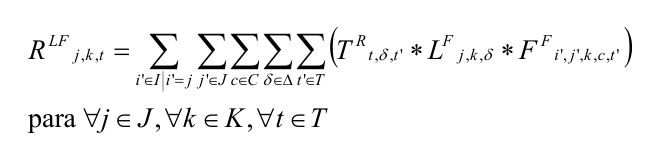

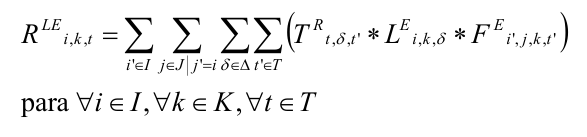

Problema: Dados.SF só tem dados para 5 portos, enquanto os outros dados chegam aos 10 portos.

Solução? Assumir que os dados para os outros portos são iguais.

In [15]:
# Restrição de quantidade de contêineres vazios devolvida de importação
count_constr = 0
for j in dados.P:
    for k in dados.K:
        for t in dados.T:
                model.addConstr(
                    RSF[j, k, t] == quicksum([dados.TR[t, delta, t_] * FF[i, j, k, c, t_] * dados.SF[(dados.SF['I'] == ordem.loc[j].values[0]) & (dados.SF['K'] == k) & (dados.SF['DT'] == delta)]['SF'].values[0] for i in dados.P for c in dados.C for delta in dados.DT for t_ in dados.T]),
                    name=f"quantidade_conteineres_vazios_devolvida_{j}_{k}_{t}"
                )
                model.addConstr(
                    RSE[j, k, t] == quicksum([dados.TR[t, delta, t_] * FE[i, j, k, t_] * dados.SE[(dados.SE['K'] == k) & (dados.SE['DT'] == delta)]['SE'].values[0] for i in dados.P for delta in dados.DT for t_ in dados.T]),
                    name=f"quantidade_conteineres_disponiveis_pos_reposicionamento_{j}_{k}_{t}"
                )
                model.addConstr(
                RLF[j, k, t] == quicksum(
                    dados.TR[t, delta, t_] * dados.LF[(j, k, delta)] * FF[i_, j_, k, c, t_]
                    for i_ in dados.P if i_ == j
                    for j_ in dados.P
                    for c in dados.C
                    for delta in dados.DT
                    for t_ in dados.T
                ),
                name=f"restricao_RLF_{j}_{k}_{t}"
                )
                model.addConstr(
                RLE[i, k, t] == quicksum(
                    dados.TR[t, delta, t_] * dados.LF[(i, k, delta)] * FE[i_, j_, k, t_]
                    for i_ in dados.P if i_ == j
                    for j_ in dados.P
                    for c in dados.C
                    for delta in dados.DT
                    for t_ in dados.T
                ),
                name=f"restricao_RLE_{i}_{k}_{t}"
                )
                count_constr += 1
print(f"Restrições de quantidade máxima de contêineres armazenada em cada porto: {count_constr}")

Restrições de quantidade máxima de contêineres armazenada em cada porto: 480


Sf e Se considera apenas porto de chegada (índice I do Excel representa J)

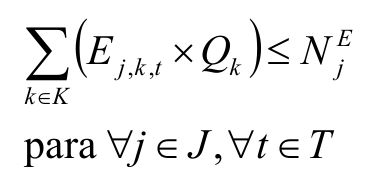

In [16]:
# Restrição de quantidade máxima de contêineres vazios em cada porto
count_constr = 0
for j in dados.P:
    for t in dados.T:
        model.addConstr(
            quicksum(E[(j, k, t)] * dados.Q[(dados.Q['K'] == k)]['Q'].values[0] for k in dados.K) <= dados.NE[(dados.NE['I'] == ordem.loc[j].values[0])]['NE'].values[0],
            name=f"restricao_quantidade_maxima_conteineres_{j}_{t}"
        )
        count_constr += 1

print(f"Restrições de quantidade máxima de contêineres vazios em cada porto: {count_constr}")

Restrições de quantidade máxima de contêineres vazios em cada porto: 120


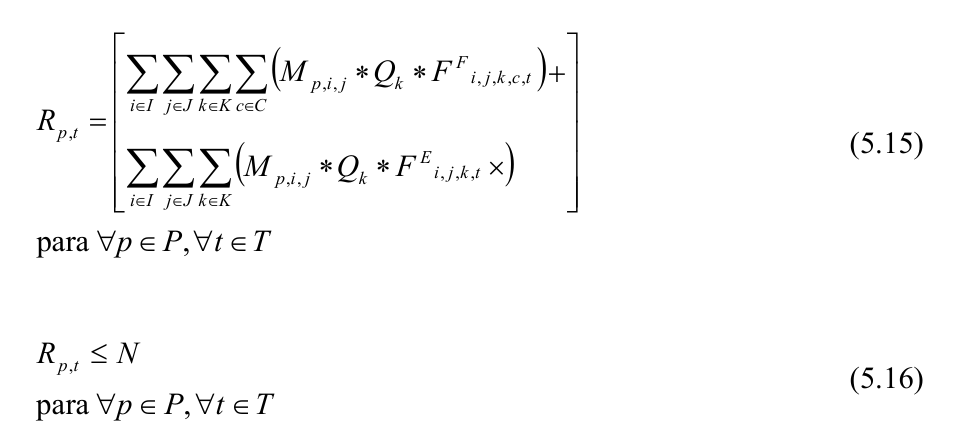

In [17]:
# Restrição (5.15) para calcular Rp,t
count_constr = 0
for p in dados.P:
    for t in dados.T:
        model.addConstr(
            R[p, t] == quicksum(
                dados.M[(dados.M['P'] == p) & (dados.M['I'] == ordem.loc[i].values[0]) & (dados.M['J'] == ordem.loc[j].values[0])]['M'].values[0]
                * dados.Q[(dados.Q['K'] == k)]['Q'].values[0] 
                * FF[i, j, k, c, t]
                for i in dados.P
                for j in dados.P
                for k in dados.K
                for c in dados.C
            ) + quicksum(
                dados.M[(dados.M['P'] == p) & (dados.M['I'] == ordem.loc[i].values[0]) & (dados.M['J'] == ordem.loc[j].values[0])]['M'].values[0]
                * dados.Q[(dados.Q['K'] == k)]['Q'].values[0] 
                * FE[i, j, k, t]
                for i in dados.P
                for j in dados.P
                for k in dados.K
            ),
            name=f"calculo_R_{p}_{t}"
        )
        count_constr += 1

# Restrição (5.16) para limitar Rp,t a N
for p in dados.P:
    for t in dados.T:
        model.addConstr(
            R[p, t] <= dados.N,
            name=f"limite_R_{p}_{t}"
        )
        count_constr += 1

print(f"Restrições adicionadas: {count_constr}")


Restrições adicionadas: 240


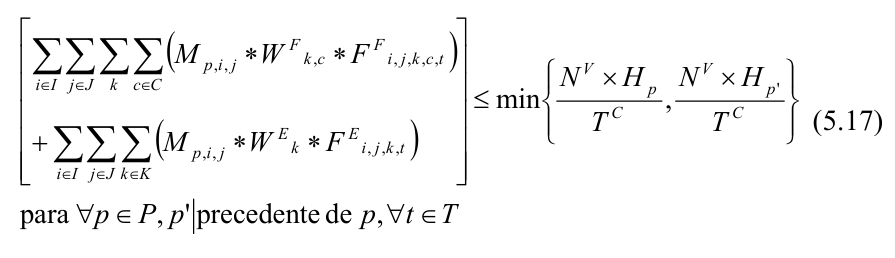

In [18]:
# Restrição de calado máximo nos portos - função de deadweight
count_constr = 0
index = -1
for p in dados.P:
    index += 1
    p_ = dados.P[index - 1]
    h = dados.H[dados.H['P'] == p]['H'].values[0]
    h_ = dados.H[dados.H['P'] == p_]['H'].values[0]
    h_value = min(h, h_)
    for t in dados.T:
        count_constr += 1
        model.addConstr(
            quicksum(
                dados.M[(dados.M['P'] == p) & (dados.M['I'] == ordem.loc[i].values[0]) & (dados.M['J'] == ordem.loc[j].values[0])]['M'].values[0]
                * dados.WF[(dados.WF['K'] == k) & (dados.WF['C'] == c)]['WF'].values[0] 
                * FF[i, j, k, c, t]
                for i in dados.P
                for j in dados.P
                for k in dados.K
                for c in dados.C
            )
            +
            quicksum(
                dados.M[(dados.M['P'] == p) & (dados.M['I'] == ordem.loc[i].values[0]) & (dados.M['J'] == ordem.loc[j].values[0])]['M'].values[0]
                * dados.WE[(dados.WE['K'] == k)]['WE'].values[0] 
                * FE[i, j, k, t]
                for i in dados.P
                for j in dados.P
                for k in dados.K
            )
            <=
            h_value * dados.NV / dados.TC,
            name=f"calado_maximo_porto_{p}_{t}"
            )
        
        # Limite de Deadweight no navio
        model.addConstr(
            quicksum(
                dados.M[(dados.M['P'] == p) & (dados.M['I'] == ordem.loc[i].values[0]) & (dados.M['J'] == ordem.loc[j].values[0])]['M'].values[0]
                * dados.WF[(dados.WF['K'] == k) & (dados.WF['C'] == c)]['WF'].values[0] 
                * FF[i, j, k, c, t]
                for i in dados.P
                for j in dados.P
                for k in dados.K
                for c in dados.C
            )
            +
            quicksum(
                dados.M[(dados.M['P'] == p) & (dados.M['I'] == ordem.loc[i].values[0]) & (dados.M['J'] == ordem.loc[j].values[0])]['M'].values[0]
                * dados.WE[(dados.WE['K'] == k)]['WE'].values[0] 
                * FE[i, j, k, t]
                for i in dados.P
                for j in dados.P
                for k in dados.K
            )
            <=
            dados.ND * dados.NV / dados.TC,
            name=f"deadweight_maximo_navio_{p}_{t}"
            )
        
print(f"Restrições de calado máximo nos portos: {count_constr}")

Restrições de calado máximo nos portos: 120


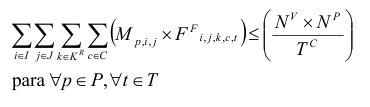

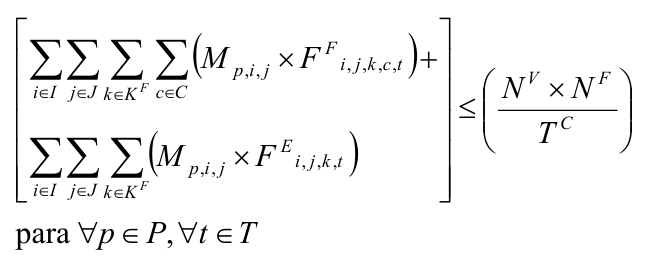

In [19]:
# Restrição de quantidade de contêineres frigoríficos cheios nos navios
count_constr = 0
for p in dados.P:
    for t in dados.T:
        count_constr += 1
        model.addConstr(
            quicksum(
                dados.M[(dados.M['P'] == p) & (dados.M['I'] == ordem.loc[i].values[0]) & (dados.M['J'] == ordem.loc[j].values[0])]['M'].values[0]
                * FF[i, j, k, c, t]
                for i in dados.P 
                for j in dados.P 
                for k in dados.K_Refrigerados 
                for c in dados.C) <= dados.NP * dados.NV / dados.TC,
            name=f"capacidade_maxima_refrigerados_{p}_{t}"
        )

In [20]:
# Restrição de quantidade de contêineres de 40 pés no navio
count_constr = 0
for p in dados.P:
    for t in dados.T:
        count_constr += 1

        model.addConstr(
            quicksum(
                dados.M[(dados.M['P'] == p) & (dados.M['I'] == ordem.loc[i].values[0]) & (dados.M['J'] == ordem.loc[j].values[0])]['M'].values[0]
                * FF[i, j, k, c, t]
                for i in dados.P
                for j in dados.P
                for k in dados.K_40pes
                for c in dados.C
            ) + quicksum(
                dados.M[(dados.M['P'] == p) & (dados.M['I'] == ordem.loc[i].values[0]) & (dados.M['J'] == ordem.loc[j].values[0])]['M'].values[0]
                * FE[i, j, k, t]
                for i in dados.P
                for j in dados.P
                for k in dados.K_40pes
            ) <= (dados.NV * dados.NF / dados.TC),
            name=f"capacidade_maxima_40_pes_{p}_{t}"
        )
print(f"Restrições de quantidade de contêineres de 40 pés nos navios: {count_constr}")


Restrições de quantidade de contêineres de 40 pés nos navios: 120


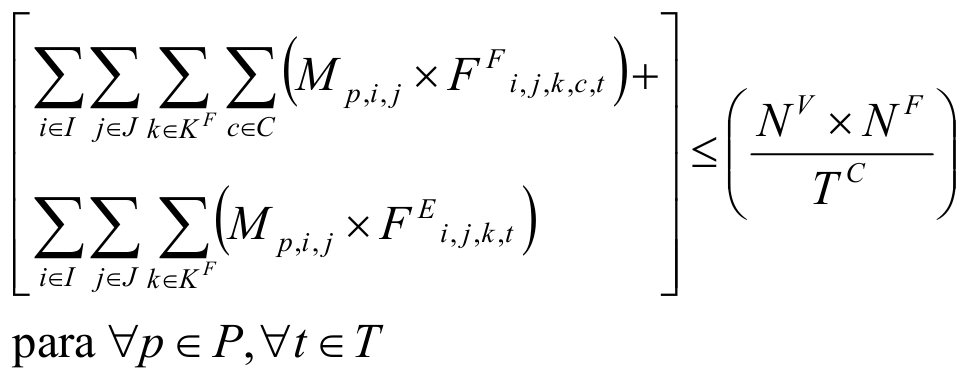

In [21]:
# Quantidade da frota utilizada vs limite

for k in dados.K:
    for t in dados.T:
        part1 = quicksum(FF[i, j, k, c, t] for i in dados.P for j in dados.P for c in dados.C)
        part2 = quicksum(FE[i, j, k, t] for i in dados.P for j in dados.P)
        part3 = quicksum(E[j, k, t] for j in dados.P)
        
        part4 = quicksum(
            dados.TR[t, delta, t_] * FF[i, j, k, c, t_] * dados.SF[(dados.SF['I'] == ordem.loc[j].values[0]) & (dados.SF['K'] == k) & (dados.SF['DT'] == delta)]['SF'].values[0] +
            dados.TR[t, delta, t_] * FE[i, j, k, t_] * dados.SE[(dados.SE['K'] == k) & (dados.SE['DT'] == delta)]['SE'].values[0]
            for i in dados.P 
            for j in dados.P 
            for c in dados.C 
            for delta in dados.DT 
            for t_ in dados.T
            if delta > 1 and dados.TR[t, delta, t_] == 1
        )

        part5 = quicksum(
            dados.TR[t, delta, t_] * dados.LF[j1, k, delta] * FF[i, j, k, c, t_] +
            dados.TR[t, delta, t_] * dados.LE[j1, k, delta] * FE[i, j, k, t_]
            for i in dados.P
            for j in dados.P 
            for j1 in dados.P 
            for c in dados.C 
            for delta in dados.DT 
            for t_ in dados.T
            if delta > 1 and dados.TR[t, delta, t_] == 1 and j1 == i
        )
        
        total_sum = part1 + part2 + part3 + part4 + part5
        
        model.addConstr(total_sum <= dados.NC[dados.NC['K'] == k]['NC'].values[0], name=f"lim_frota_{k}_{t}")

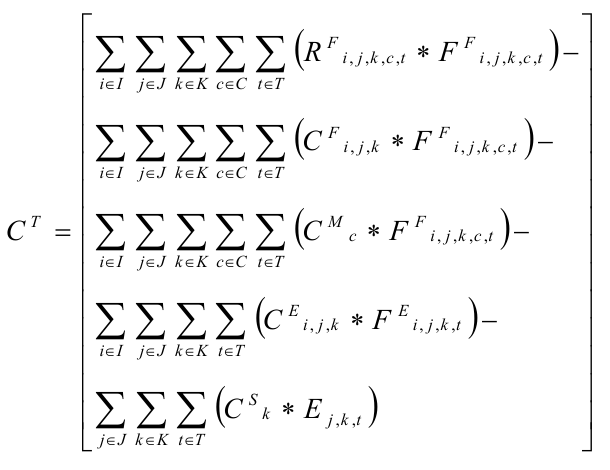

In [22]:
# # Função para obter o valor de um DataFrame filtrado com valor padrão se vazio
# def get_value(df, condition, column):
#     filtered = df[condition]
#     if not filtered.empty:
#         return filtered[column].values[0]
#     else:
#         return 0

# # Defina a função objetivo
# model.setObjective(
#     quicksum(
#         (
#             get_value(
#                 dados.RF, 
#                 (dados.RF['I'] == ordem.loc[i].values[0]) & 
#                 (dados.RF['J'] == ordem.loc[j].values[0]) & 
#                 (dados.RF['K'] == k) & 
#                 (dados.RF['C'] == c) & 
#                 (dados.RF['T'] == t), 
#                 'RF'
#             ) * FF[i, j, k, c, t] -
#             get_value(
#                 dados.CF, 
#                 (dados.CF['I'] == ordem.loc[i].values[0]) & 
#                 (dados.CF['J'] == ordem.loc[j].values[0]) & 
#                 (dados.CF['K'] == k), 
#                 'CF'
#             ) * FF[i, j, k, c, t] -
#             get_value(
#                 dados.CM, 
#                 (dados.CM['C'] == c), 
#                 'CM'
#             ) * FF[i, j, k, c, t]
#         )
#         for i in dados.P for j in dados.P for k in dados.K for c in dados.C for t in dados.T
#     ) -
#     quicksum(
#         get_value(
#             dados.CE, 
#             (dados.CE['I'] == ordem.loc[i].values[0]) & 
#             (dados.CE['J'] == ordem.loc[j].values[0]) & 
#             (dados.CE['K'] == k), 
#             'CE'
#         ) * FE[i, j, k, t]
#         for i in dados.P for j in dados.P for k in dados.K for t in dados.T
#     ) -
#     quicksum(
#         get_value(
#             dados.CS, 
#             (dados.CS['K'] == k), 
#             'CS'
#         ) * E[j, k, t]
#         for j in dados.P for k in dados.K for t in dados.T
#     ),
#     GRB.MAXIMIZE
# )

In [23]:
# Função para obter o valor de um DataFrame filtrado com valor padrão se vazio
def get_value(df, condition, column):
    filtered = df[condition]
    if not filtered.empty:
        return filtered[column].values[0]
    else:
        return 0

# Defina a função objetivo
model.setObjective(
    quicksum(
        (
            get_value(
                dados.RF, 
                (dados.RF['I'] == i) & 
                (dados.RF['J'] == j) & 
                (dados.RF['K'] == k) & 
                (dados.RF['C'] == c) & 
                (dados.RF['T'] == t), 
                'RF'
            ) * FF_port[i, j, k, c, t] -
            get_value(
                dados.CF, 
                (dados.CF['I'] == i) & 
                (dados.CF['J'] == j) & 
                (dados.CF['K'] == k), 
                'CF'
            ) * FF_port[i, j, k, c, t] -
            get_value(
                dados.CM, 
                (dados.CM['C'] == c), 
                'CM'
            ) * FF_port[i, j, k, c, t]
        )
        for i in port_nums for j in port_nums for k in dados.K for c in dados.C for t in dados.T
    ) -
    quicksum(
        get_value(
            dados.CE, 
            (dados.CE['I'] == ordem.loc[i].values[0]) & 
            (dados.CE['J'] == ordem.loc[j].values[0]) & 
            (dados.CE['K'] == k), 
            'CE'
        ) * FE[i, j, k, t]
        for i in dados.P for j in dados.P for k in dados.K for t in dados.T
    ) -
    quicksum(
        get_value(
            dados.CS, 
            (dados.CS['K'] == k), 
            'CS'
        ) * E[j, k, t]
        for j in dados.P for k in dados.K for t in dados.T
    ),
    GRB.MAXIMIZE
)

In [24]:
# Otimizar o modelo
model.optimize()

# Verificar o status do modelo para garantir que encontrou uma solução ótima
if model.status == GRB.OPTIMAL:
    print('Solução ótima encontrada.')
    
    # Imprimir o valor da função objetivo
    print('Valor da função objetivo: ', model.objVal)
    
    # Imprimir os valores das variáveis de decisão
    for v in model.getVars():
        print(f'{v.varName}: {v.x}')
else:
    print('Não foi possível encontrar uma solução ótima.')

# Adicionalmente, se você deseja acessar valores específicos de variáveis:
# Por exemplo, se quiser imprimir valores de uma variável específica como FF[i, j, k, c, t]
for i in dados.P:
    for j in dados.P:
        for k in dados.K:
            for c in dados.C:
                for t in dados.T:
                    if FF[i, j, k, c, t].x > 0:  # Apenas imprime valores diferentes de zero
                        print(f'FF[{i},{j},{k},{c},{t}] = {FF[i, j, k, c, t].x}')


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 14808 rows, 19321 columns and 186480 nonzeros
Model fingerprint: 0xda2aecbe
Coefficient statistics:
  Matrix range     [1e-01, 3e+01]
  Objective range  [2e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+05]
Presolve removed 12880 rows and 12457 columns
Presolve time: 0.30s
Presolved: 1928 rows, 6864 columns, 63200 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.14s

Barrier statistics:
 AA' NZ     : 4.552e+04
 Factor NZ  : 1.971e+05 (roughly 4 MB of memory)
 Factor Ops : 3.940e+07 (less than 1 second per iteration)
 Threads    : 3

Barrier performed 0 iterations in 0.62 seconds (0.08 work units)
Barrier solve interrupted - model solved by

In [25]:
# model.write("Resultados_extremo_df_e_rf_51318_pos_ajuste_Obj_FF.sol")

In [26]:
# I J K C T = 5 1 3 1 1 na ordem
# 5 na ordem 2 e 9
# 1 na ordem 4 e 7

Resultados não mudaram entre caso padrão e extremo...

Alterei demanda de 5 1 3 1 1 (nos índices de porto, e não de posição na rota)

Pode ser por conta de uma limitação de calado?

Será melhor aumentar o valor do frete em vez da demanda disponível?

Se a limitação é o calado / tamanho do navio em vez da demanda, aumentar este não melhora o resultado...

In [27]:
FF[2,4,3,1,1].x

166.0

In [28]:
FF[9,4,3,1,1].x

0.0

In [29]:
FF[4,9,3,1,1].x

0.0

In [30]:
FF[7,9,3,1,1].x

40.0

In [31]:
FF[5,9,3,1,1].x

80.0

In [32]:
FF[6,9,3,1,1].x

0.0

In [33]:
for i in range(1, 6):
    for j in range(1, 6):
        if i != j:
            print(f'FF[{i}, {j}] = {FF_port[i,j,3,1,1].x}')

FF[1, 2] = 15.0
FF[1, 3] = 241.0
FF[1, 4] = 1745.0
FF[1, 5] = 40.0
FF[2, 1] = 761.0
FF[2, 3] = 0.0
FF[2, 4] = 151.0
FF[2, 5] = 0.0
FF[3, 1] = 1049.0
FF[3, 2] = 0.0
FF[3, 4] = 2.0
FF[3, 5] = 80.0
FF[4, 1] = 1403.0
FF[4, 2] = 36.0
FF[4, 3] = 234.0
FF[4, 5] = 0.0
FF[5, 1] = 166.0
FF[5, 2] = 37.0
FF[5, 3] = 125.0
FF[5, 4] = 0.0


In [34]:
dados.DF[ordem.loc[4].values[0], ordem.loc[9].values[0], 3, 1, 1]

40.5522914218566

In [35]:
FF_port[ordem.loc[5].values[0], ordem.loc[9].values[0], 3, 1, 1].x

80.0

In [36]:
dados.N

11440.860215053763

In [37]:
R[8,8].x

8214.053391103811

In [38]:
ordem

,IdPorto
1,2
2,5
3,4
4,1
5,3
6,3
7,1
8,4
9,5
10,2


In [39]:
ordem.iloc[4].values[0]

3

O segundo (índice 9) deveria ser zero (?)

Pq passa pelo mesmo porto no índice 2, então está carregando o contêiner a toa entre 9 >10; 10>1; 1>2 = mais custo

In [40]:
FF[2,5,3,1,2].x

212.0

In [41]:
FF[2,6,3,1,2].x

0.0

In [73]:
model.write("Resultados_ajuste_v1.sol")

In [43]:
FF[2,4,3,1,8].x

260.0

In [44]:
FF[9,4,3,1,8].x

0.0

## Caso com erro

In [45]:
# 4 e 7 são porto 1, 8 é o 4
FF[4,8,3,1,1].x

1745.0

In [46]:
FF[7,8,3,1,1].x

0.0

In [47]:
# DF 1 --> 4 é ~1700
# A demanda total ainda é abaixo (~1100) mas deveria ser pega no índice 7...
# Possível problema no custo da função objetivo?
# Não tem custo direto por tempo de permanência no navio, o custo deveria ser oportunidade perdida de outras cargas...

In [48]:
# Estamos pegando o total para o porto 3? (1 > 3)
FF[4,5,3,1,1].x

0.0

In [49]:
# SIM
dados.DF[1,3,3,1,1]

241.454889146173

In [50]:
# e do 4 > 3
FF[3,5,3,1,1].x

234.0

In [51]:
dados.DF[4,3,3,1,1]

234.851097141126

In [52]:
FF[8,5,3,1,1].x

0.0

In [53]:
ordem

,IdPorto
1,2
2,5
3,4
4,1
5,3
6,3
7,1
8,4
9,5
10,2


In [54]:
for j in range(1, 10):
    print(j, FF[j,5,3,1,1].x + FF[j,6,3,1,1].x)

1 0.0
2 125.0
3 234.0
4 241.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0


In [55]:
for j in range(1, 10):
    print(j, round(FF[1,j,3,1,1].x,0), round(dados.DF[1,ordem.loc[j].values[0],3,1,1], 0))

1 0.0 16.0
2 0.0 41.0
3 151.0 1745.0
4 761.0 0
5 0.0 241.0
6 0.0 241.0
7 0.0 0
8 0.0 1745.0
9 0.0 41.0


In [56]:
for j in range(1, 10):
    print(j, FF[j,7,3,1,1].x)

1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 1049.0
7 0.0
8 0.0
9 0.0


In [57]:
for j in range(1, 10):
    print(j, FF[j,4,3,1,1].x)

1 761.0
2 166.0
3 1403.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0


In [58]:
# Restrição de calado máximo nos portos
count_constr = 0
index = -1
for p in dados.P:
    index += 1
    p_ = dados.P[index - 1]
    h = dados.H[dados.H['P'] == p]['H'].values[0]
    h_ = dados.H[dados.H['P'] == p_]['H'].values[0]
    h_value = min(h, h_)
    for t in range(1,2): #dados.T:
        count_constr += 1
        calado = quicksum(
                dados.M[(dados.M['P'] == p) & (dados.M['I'] == ordem.loc[i].values[0]) & (dados.M['J'] == ordem.loc[j].values[0])]['M'].values[0]
                * dados.WF[(dados.WF['K'] == k) & (dados.WF['C'] == c)]['WF'].values[0] 
                * FE[i, j, k, t].x
                for i in dados.P
                for j in dados.P
                for k in dados.K
                for c in dados.C
            ) + quicksum(
                dados.M[(dados.M['P'] == p) & (dados.M['I'] == ordem.loc[i].values[0]) & (dados.M['J'] == ordem.loc[j].values[0])]['M'].values[0]
                * dados.WE[(dados.WE['K'] == k)]['WE'].values[0] 
                * FE[i, j, k, t].x
                for i in dados.P
                for j in dados.P
                for k in dados.K
            )
        calado_max = h_value * dados.NV / dados.TC,
        name=f"calado_maximo_porto_{p}_{t}"
        print(name, calado_max, calado)
            
# print(f"Restrições de calado máximo nos portos: {count_constr}")

calado_maximo_porto_1_1 (195149.29411322795,) 0.0
calado_maximo_porto_2_1 (195149.29411322795,) 5466.753162087495
calado_maximo_porto_3_1 (195149.29411322795,) 13570.585706158245
calado_maximo_porto_4_1 (195149.29411322795,) 3025.350713116766
calado_maximo_porto_5_1 (195149.29411322795,) 5470.971117331889
calado_maximo_porto_6_1 (195149.29411322795,) 0.0
calado_maximo_porto_7_1 (195149.29411322795,) 6080.021336940563
calado_maximo_porto_8_1 (195149.29411322795,) 31667.124789719892
calado_maximo_porto_9_1 (195149.29411322795,) 19597.985146950214
calado_maximo_porto_10_1 (195149.29411322795,) 20441.25613425808


In [59]:
# Parece que calado saindo do porto 2 (5) está zero, mas é o porto de saída de maior quantidade...
for j in range(1, 11):
    print(j, round(FF[2,j,3,1,1].x,0), round(dados.DF[5,ordem.loc[j].values[0],3,1,1], 0))

1 0.0 38.0
2 0.0 0
3 0.0 0.0
4 166.0 166.0
5 0.0 125.0
6 125.0 125.0
7 0.0 166.0
8 0.0 0.0
9 0.0 0
10 0.0 38.0


In [60]:
# Parece que calado saindo do porto 2 (5) está zero, mas é o porto de saída de maior quantidade...
for j in range(1, 11):
    print(j, round(FF[2,j,3,1,8].x,0), round(dados.DF[5,ordem.loc[j].values[0],3,1,8], 0))

1 0.0 8.0
2 0.0 0
3 0.0 0.0
4 260.0 260.0
5 0.0 66.0
6 65.0 66.0
7 0.0 260.0
8 0.0 0.0
9 0.0 0
10 0.0 8.0


In [61]:
import matplotlib.pyplot as plt

# Frota disponível seria o limite?

In [62]:
for k in range(3,4): #dados.K:
    for t in dados.T:
        part1 = quicksum(FF[i, j, k, c, t].x for i in dados.P for j in dados.P for c in dados.C)
        part2 = quicksum(FE[i, j, k, t].x for i in dados.P for j in dados.P)
        part3 = quicksum(E[j, k, t].x for j in dados.P)
        
        part4 = quicksum(
            dados.TR[t, delta, t_] * FF[i, j, k, c, t_].x * dados.SF[(dados.SF['I'] == ordem.loc[j].values[0]) & (dados.SF['K'] == k) & (dados.SF['DT'] == delta)]['SF'].values[0] +
            dados.TR[t, delta, t_] * FE[i, j, k, t_].x * dados.SE[(dados.SE['K'] == k) & (dados.SE['DT'] == delta)]['SE'].values[0]
            for i in dados.P 
            for j in dados.P 
            for c in dados.C 
            for delta in dados.DT 
            for t_ in dados.T
            if delta > 1 and dados.TR[t, delta, t_] == 1
        )

        part5 = quicksum(
            dados.TR[t, delta, t_] * dados.LF[j1, k, delta] * FF[i, j, k, c, t_].x +
            dados.TR[t, delta, t_] * dados.LE[j1, k, delta] * FE[i, j, k, t_].x
            for i in dados.P
            for j in dados.P 
            for j1 in dados.P 
            for c in dados.C 
            for delta in dados.DT 
            for t_ in dados.T
            if delta > 1 and dados.TR[t, delta, t_] == 1 and j1 == i
        )
        
        total_sum = part1 + part2 + part3 + part4 + part5
        print(f"Max Frota conteiner {k}_{t}: {dados.NC[dados.NC['K'] == k]['NC'].values[0]} vs utilizada: {total_sum}")
        
        # model.addConstr(total_sum <= dados.NC[dados.NC['K'] == k]['NC'].values[0], name=f"lim_frota_{k}_{t}")

Max Frota conteiner 3_1: 50000 vs utilizada: 11818.800704896426
Max Frota conteiner 3_2: 50000 vs utilizada: 11608.613701655402
Max Frota conteiner 3_3: 50000 vs utilizada: 11671.818722550202
Max Frota conteiner 3_4: 50000 vs utilizada: 11964.566301576928
Max Frota conteiner 3_5: 50000 vs utilizada: 10419.638585551804
Max Frota conteiner 3_6: 50000 vs utilizada: 11908.5877413291
Max Frota conteiner 3_7: 50000 vs utilizada: 11429.249786557579
Max Frota conteiner 3_8: 50000 vs utilizada: 11952.38944094069
Max Frota conteiner 3_9: 50000 vs utilizada: 10437.59261990972
Max Frota conteiner 3_10: 50000 vs utilizada: 10843.43014981357
Max Frota conteiner 3_11: 50000 vs utilizada: 10715.655015316894
Max Frota conteiner 3_12: 50000 vs utilizada: 11424.707229901733


Frota não considera saida porto a porto... (?)

Mas ainda assim, está sobrando

E estranho que muda pouco, inclusivo no período 8, em que coloquei um frete muito alto no tipo  k = 3

# Frigoríficos Cheios (?)

Restrições de quantidade de contêineres frigoríficos cheios nos navios: 120


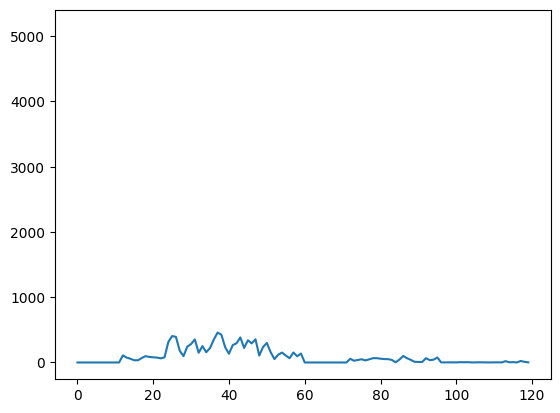

In [63]:
# Restrição de quantidade de contêineres frigoríficos cheios nos navios
frig_cheios = []
count_constr = 0
for p in dados.P:
    for t in dados.T:
        count_constr += 1

        frigorificos = quicksum(
                dados.M[(dados.M['P'] == p) & (dados.M['I'] == ordem.loc[i].values[0]) & (dados.M['J'] == ordem.loc[j].values[0])]['M'].values[0]
                * FF[i, j, k, c, t].x
                for i in dados.P
                for j in dados.P
                for k in dados.K_Refrigerados
                for c in dados.C
            )
        
        frig_cheios.append(frigorificos.getValue())
        # limite = (dados.NV * dados.NF / dados.TC),
        name=f"capacidade_maxima_refrigerados_{p}_{t}"
        # print(name, frigorificos)
limite = (dados.NV * dados.NF / dados.TC),

plt.plot(frig_cheios)
plt.plot(limite)

print(f"Restrições de quantidade de contêineres frigoríficos cheios nos navios: {count_constr}")


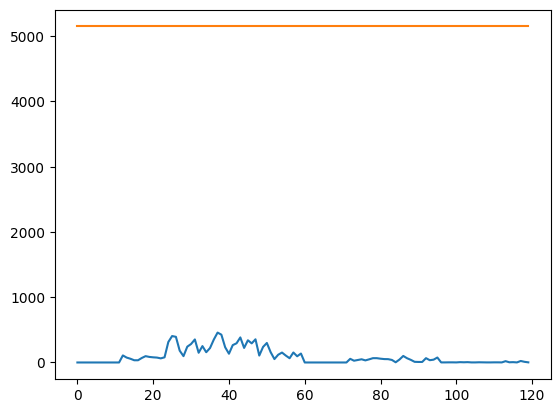

In [64]:
plt.plot(frig_cheios)
plt.plot([limite]*len(frig_cheios))

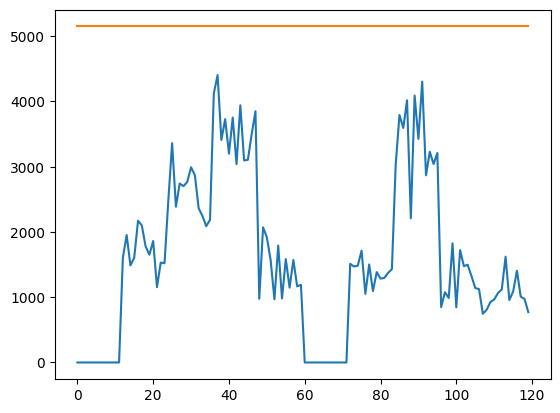

In [69]:
# Restrição de quantidade de contêineres de 40 pés no navio
count_constr = 0
lista_40_pes = []
for p in dados.P:
    for t in dados.T:
        count_constr += 1

        qtd_40_pes = quicksum(
                dados.M[(dados.M['P'] == p) & (dados.M['I'] == ordem.loc[i].values[0]) & (dados.M['J'] == ordem.loc[j].values[0])]['M'].values[0]
                * FF[i, j, k, c, t].x
                for i in dados.P
                for j in dados.P
                for k in dados.K
                for c in dados.C
            ) + quicksum(
                dados.M[(dados.M['P'] == p) & (dados.M['I'] == ordem.loc[i].values[0]) & (dados.M['J'] == ordem.loc[j].values[0])]['M'].values[0]
                * FE[i, j, k, t].x
                for i in dados.P
                for j in dados.P
                for k in dados.K
            ) 
        lista_40_pes.append(qtd_40_pes.getValue())
max_40_pes = (dados.NV * dados.NF / dados.TC)

plt.plot(lista_40_pes)
plt.plot([max_40_pes]*len(lista_40_pes))

In [66]:
model.write("correcao_vetor_pi_v1.lp")

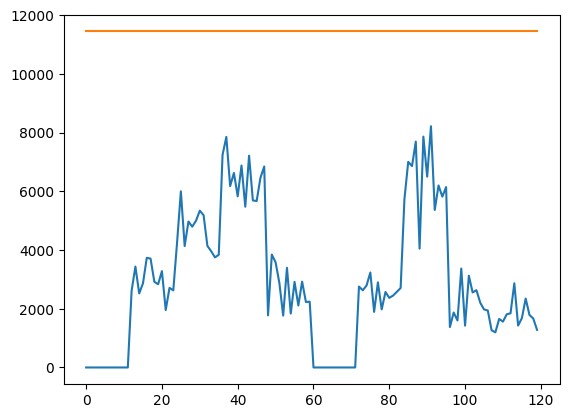

In [67]:
R_array = []
for p in dados.P:
    for t in dados.T:
        R_array.append(R[p,t].x)

plt.plot(R_array)
plt.plot([dados.N]*len(R_array))

In [71]:
for constr in model.getConstrs():
    if constr.Pi > 0:
        print(f"{constr.ConstrName}:{constr.Pi}")

participacao_maxima_armador_2_1_4_2_6:1264.1992866943988
participacao_maxima_armador_2_1_4_2_10:1264.0000019485637
participacao_maxima_armador_2_1_4_2_11:1263.9999824629253
participacao_maxima_armador_3_1_1_1_1:14.999999999999886
participacao_maxima_armador_3_1_1_1_2:14.99999999999983
participacao_maxima_armador_3_1_1_1_3:15.000000000000625
participacao_maxima_armador_3_1_1_1_4:15.0
participacao_maxima_armador_3_1_1_1_5:14.999999999999943
participacao_maxima_armador_3_1_1_1_6:14.999999999999204
participacao_maxima_armador_3_1_1_1_7:14.999999999999659
participacao_maxima_armador_3_1_1_1_8:15.0
participacao_maxima_armador_3_1_1_1_9:15.000000000000682
participacao_maxima_armador_3_1_1_1_10:15.0
participacao_maxima_armador_3_1_1_1_11:14.999999999999773
participacao_maxima_armador_3_1_1_1_12:15.000000000000227
participacao_maxima_armador_3_1_1_2_1:14.999999999999886
participacao_maxima_armador_3_1_1_2_2:14.99999999999983
participacao_maxima_armador_3_1_1_2_3:15.000000000000625
participacao_